# Import packages

In [1]:
# Pytorch packages
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import transforms
from torchinfo import summary

import os
import pandas as pd

import glob
import csv
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# Plotting
import matplotlib.pyplot as plt

# Select device (CPU or GPU)

## Configure device

In [3]:
# Determine the device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


# Read the data

## Create the custom data loader

In [5]:
# Custom dataset class
class FileDataset(Dataset):
    def __init__(self, root_dir, channels, sample_interval, transform=None):
        self.root_dir = root_dir
        
        self.channels = channels
        self.sample_interval = sample_interval
        
        self.transform = transform
        self.file_list = []
        self.labels = []
        
        # The number of classes
        self.n_classes = 0

        # Extract file paths and labels
        self._extract_file_paths()
        
         # Perform label encoding as one-hot encoding
        self._encode_labels()

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        file_path = self.file_list[idx]
        label = self.labels[idx]

        # Read the file
        data = self._read_file(file_path)

        # Apply transformation if provided
        if self.transform:
            data = self.transform(data)

        return data, label

    def _extract_file_paths(self):
        label_dirs = os.listdir(self.root_dir)

        for label in label_dirs:
            label_dir = os.path.join(self.root_dir, label)
            if os.path.isdir(label_dir):
                files = glob.glob(os.path.join(label_dir, '*.csv'))
                self.file_list.extend(files)
                self.labels.extend([label] * len(files))

    def _read_file(self, file_path):
        
        signal_data = np.loadtxt(file_path, dtype=np.float32, delimiter=",")
        # Transform to torch vector and reshape to column vector
        return torch.from_numpy(signal_data)
        
        # Implement your own file reading logic here
        # For example, if you're working with CSV files, you can use pandas
        # dataframe = pd.read_csv(file_path)
        # return dataframe.values

        # In this example, we assume a simple text file and read its content
        #with open(file_path, 'r') as file:
        #    content = file.read()

        #return content
        
    def _encode_labels(self):
        
        label_encoder = LabelEncoder()
        integer_encoded = label_encoder.fit_transform(self.labels)
        
        # Print the original classes names
        #print(label_encoder.classes_)
        
        # Reshape to column vector
        integer_encoded = integer_encoded.reshape(-1, 1)

        # JCPS "sparse" deprecated in version 1.2, use "sparse_output" from version 1.4
        #onehot_encoder = OneHotEncoder(sparse=False)
        onehot_encoder = OneHotEncoder(sparse_output=False)
        
        onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
        
        self.n_classes = onehot_encoded.shape[1]
        
        self.labels = torch.tensor(onehot_encoded, dtype=torch.float32)
        #self.labels = torch.tensor(onehot_encoded, dtype=torch.long)


## Define transformations for the raw data

In [6]:
# Reshape the raw data to a row vector

class ToRowVector(object):
    """Transforms the input signal to a row vector"""
    
    def __call__(self, sample):
        #reshaped_sample = sample.view(1, -1)
        #print(sample.shape[0])
        #print(sample.shape[1])
        
        # Slide the data, use only the first row
        preshaped = sample[0,:]
                        
        #reshaped_sample = sample.view(sample.shape[0]*sample.shape[1])
        reshaped_sample = preshaped.view(preshaped.shape[0])
        
        #return sample
        return reshaped_sample

# Subsample signal extracting only selected channels and gor a given sample interval
class SignalSubSample(object):
    
    def __init__(self, channels, sample_interval):
        """
        Initialize input arguments.
        """
        self.channels = channels
        self.sample_interval = sample_interval
    
    def __call__(self, sample):
            
        # Get the indices of the columns to extract
        indexes_columns = list(range(0, sample.shape[1], sample_interval))  # Select every "sample_interval" column
        
        # Extract selected channels and rows
        subsample_signal = sample[channels, :][:, indexes_columns]                
        
        #print(subsample_signal.shape)
                               
        #return sample
        return subsample_signal

## Instantiate the data loader

In [12]:
# The folder with the dataset
trainig_folder_name = "../02_python_signal_folder_sorting/test_code/training_set"
testing_folder_name = "../02_python_signal_folder_sorting/test_code/testing_set"
batch_size = 10

# Specify the channels to work with
channels = [0] # one channel
#channels = [0, 4, 8, 12, 16, 20, 24, 28, 32] # eight channels

# Specify the sample interval
#sample_interval = 10
sample_interval = 1

# Create training datasets
training_dataset = FileDataset(trainig_folder_name, channels, 
                            sample_interval, 
                            transform=transforms.Compose([
                                SignalSubSample(channels, sample_interval)
                            ]))

# Create testing datasets
testing_dataset = FileDataset(testing_folder_name, channels, 
                            sample_interval, 
                            transform=transforms.Compose([
                                SignalSubSample(channels, sample_interval)
                            ]))

#train_dataset = FileDataset(folder_name, channels, 
#                            sample_interval, 
#                            transform=transforms.Compose([
#                                ToRowVector()
#                            ]))
#train_dataset = FileDataset(folder_name)
train_loader = DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(testing_dataset, batch_size=batch_size, shuffle=False)
print("Train loader: Total number of batches {} using {} items per batch. Total samples {}".format(len(train_loader), batch_size, len(train_loader) * batch_size))
print("Test loader: Total number of batches {} using {} items per batch. Total samples {}".format(len(test_loader), batch_size, len(test_loader) * batch_size))

Train loader: Total number of batches 7 using 10 items per batch. Total samples 70
Test loader: Total number of batches 3 using 10 items per batch. Total samples 30


# Define the Neural Network

In [13]:
# Define the neural network architecture
class BaseClassifier(nn.Module):
    def __init__(self, n_input_data_x, n_input_data_y, n_output):
        super(BaseClassifier, self).__init__()
           
        # Define your layers here   
        
        #self.linear1 = nn.Linear(in_dim, 1024, bias=True)
        #self.linear2 = nn.Linear(1024, 256)
        #self.relu = nn.ReLU()
        #self.linear3 = nn.Linear(256, out_dim)
     
        input_features = n_input_data_x * n_input_data_y
    
        self.linear1 = nn.Linear(input_features, 128, bias=True)
        self.linear2 = nn.Linear(128, 32)
        self.relu = nn.ReLU()
        self.linear3 = nn.Linear(32, n_output)

    def forward(self, x):
        
        #print("Before the flattening")
        #print(x.shape[0])
        #print(x.shape[1])
        #print(x.shape)
        
        # Perform the flattening of the input data to pass through the linear layers
        #reshaped_sample = sample.view(sample.shape[0]*sample.shape[1])
        x = x.view(x.shape[0], -1)
        
        #print("After the flattening")
        #print(x.shape[0])
        #print(x.shape[1])
        #print(x.shape)
        
        # Define the forward pass of your networkloss.item())
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.relu(x)
        x = self.linear3(x)
                
        return x

# Instantiate the model, optimiser and hyperparameter(s)

## Set hyperparameters

In [14]:
# Get the number of channels on the processing signal
n_channels = len(channels)

# Original number of data per channel
n_original_data_per_channel = 60000

# Get the number of data per channel
n_data_per_channel = n_original_data_per_channel // sample_interval # Integer division

#n_input_features = 2040000
n_input_features = n_channels * n_data_per_channel # input dimension
print("Number of input feautres: {}\n".format(n_input_features))

n_output_classes = 4 # output dimension

# Create an instance of the neural network and move it to the device
net = BaseClassifier(n_channels, n_data_per_channel, n_output_classes).to(device)

#net.cuda()
#net.cpu()

# Define the loss function
# Cross-entropy
criterion = nn.CrossEntropyLoss()

# Mean Square Error
#criterion = nn.MSELoss()

# Define the number of epochs
n_epochs = 4

# Define the optimiser (with its corresponding learning rate)
learning_rate = 1e-3
# Use Adam optimiser
opt = optim.Adam(net.parameters(), lr=learning_rate)

# Stochastic Gradient Descent
#opt = optim.SGD(net.parameters(), lr=learning_rate)

# Summary of the model
for p in net.parameters():
    print(p.shape)

# Summary of the model
#summary(net, input_size = (batch_size, 2040000, 4))
summary(net, input_size = (batch_size, n_input_features))
#summary(net)

Number of input feautres: 60000

torch.Size([128, 60000])
torch.Size([128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([4, 32])
torch.Size([4])


Layer (type:depth-idx)                   Output Shape              Param #
BaseClassifier                           [10, 4]                   --
├─Linear: 1-1                            [10, 128]                 7,680,128
├─ReLU: 1-2                              [10, 128]                 --
├─Linear: 1-3                            [10, 32]                  4,128
├─ReLU: 1-4                              [10, 32]                  --
├─Linear: 1-5                            [10, 4]                   132
Total params: 7,684,388
Trainable params: 7,684,388
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 76.84
Input size (MB): 2.40
Forward/backward pass size (MB): 0.01
Params size (MB): 30.74
Estimated Total Size (MB): 33.15

# Train the model

Epoch [1/4], Batch Loss: 45.3774
Epoch [1/4], Batch Loss: 43.5527
Epoch [1/4], Batch Loss: 328.9096
Epoch [1/4], Batch Loss: 65.9856
Epoch [1/4], Batch Loss: 172.5015
Epoch [1/4], Batch Loss: 74.5242
Epoch [1/4], Batch Loss: 192.9147
Epoch: 1 training loss: 131.9665
Epoch [2/4], Batch Loss: 47.9973
Epoch [2/4], Batch Loss: -0.0000
Epoch [2/4], Batch Loss: 164.5239
Epoch [2/4], Batch Loss: 375.9781
Epoch [2/4], Batch Loss: 212.8666
Epoch [2/4], Batch Loss: 319.1371
Epoch [2/4], Batch Loss: 30.8342
Epoch: 2 training loss: 164.4767
Epoch [3/4], Batch Loss: 57.2098
Epoch [3/4], Batch Loss: 0.7139
Epoch [3/4], Batch Loss: 31.2084
Epoch [3/4], Batch Loss: -0.0000
Epoch [3/4], Batch Loss: 21.7873
Epoch [3/4], Batch Loss: -0.0000
Epoch [3/4], Batch Loss: 54.4837
Epoch: 3 training loss: 23.6290
Epoch [4/4], Batch Loss: -0.0000
Epoch [4/4], Batch Loss: -0.0000
Epoch [4/4], Batch Loss: 17.3866
Epoch [4/4], Batch Loss: 1.8923
Epoch [4/4], Batch Loss: 30.2109
Epoch [4/4], Batch Loss: -0.0000
Epoch 

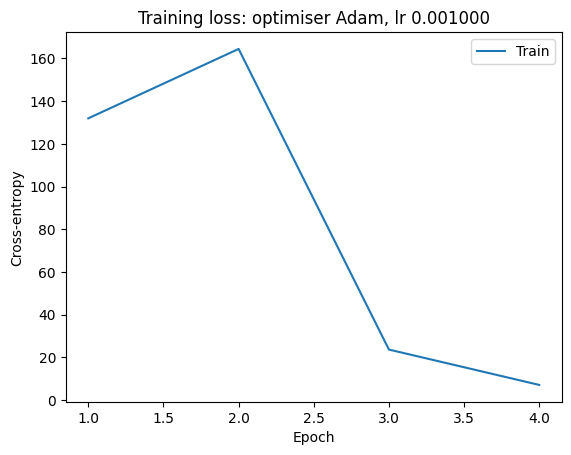

In [15]:
# Define the training method
def train(model=net,
          optimizer=opt,
          n_epochs=n_epochs,
          loss_fn=criterion,
          lr=learning_rate):
    
    # Indicate the Pytorch backend we are on training mode
    model.train()
    loss_lt = []
    
    # Training loop
    for epoch in range(n_epochs):
        running_loss = 0.0
        for batch_data, batch_labels in train_loader:
        
            # Prior any operation clear the gradient
            optimizer.zero_grad()
        
            # Move data and labels to the device
            batch_data = batch_data.to(device)
            batch_labels = batch_labels.to(device)
        
            # Forward pass
            outputs = model(batch_data)

            #print("Outputs\n")
            #print(outputs)
        
            #print("Batch labels\n")
            #print(batch_labels)
        
            # Apply the loss function
            loss = loss_fn(outputs, batch_labels)

            # Backpropagation and optimization
            loss.backward()
        
            # Perform an optimization step (this updates the weights and bias on the network)
            optimizer.step()
                    
            # Keep track of sum of loss of each batch
            running_loss+=loss.item()
                
            # Print the loss for monitoring
            print('Epoch [{}/{}], Batch Loss: {:.4f}'.format(epoch+1, n_epochs, loss.item()))
        
        # Add the cumulative loss to a list
        loss_lt.append(running_loss/len(train_loader))
        
        # Print the total loss of the epoch
        print('Epoch: {} training loss: {:.4f}'.format(epoch+1, running_loss/len(train_loader)))
        
    plt.plot([i for i in range(1, n_epochs+1)], loss_lt, label="Train")
    plt.xlabel("Epoch")
    plt.ylabel("Cross-entropy")
    plt.title("Training loss: optimiser {}, lr {:.6f}".format("Adam", lr))
    plt.legend()
    plt.show()

# Save the trained model
#torch.save(net.state_dict(), "./trained_model/model.pt')

# Call the training method
train(net, opt, n_epochs, criterion)

# Test the model

In [16]:
# Define a helper function to generate a one-hot encoding at the position of the maximum value
def generate_max_indices_tensor(input_tensor):
    # Compute the maximum along each row
    max_values, max_indices = torch.max(input_tensor, dim=1)
    
    # Create a tensor of zeros with the same shape as the input tensor
    output_tensor = torch.zeros_like(input_tensor)
    
    # Set ones at the indices of the maximum values
    output_tensor.scatter_(1, max_indices.unsqueeze(1), 1)
    
    return output_tensor

# Define a helper function that returns a one tensor if the input tensors are equal
def compare_tensors(tensor1, tensor2):
    
    # Ensure both tensors have the same shape
    assert tensor1.shape == tensor2.shape, "Both tensors should have the same dimensions."

    # Calculate element-wise equality and count equal rows
    row_equality = torch.all(tensor1 == tensor2, dim=1)
    equal_rows = torch.sum(row_equality).item()

    # Count different rows
    different_rows = tensor1.shape[0] - equal_rows
    
    return torch.tensor([equal_rows, different_rows])
        
# Define the testing method
def test(model=net,
        loss_fn=criterion):
    
    # Indicate the Pytorch backend we are on testing mode
    model.eval()
    accuracy = 0.0
    total_loss = 0.0
    
    batch_loss = 0.0
    batch_accuracy = 0.0
    
    # Use no grad to reduce memory and computation cost
    with torch.no_grad():
                
        for batch_data, batch_labels in test_loader:
            
            # Move data and labels to the device
            batch_data = batch_data.to(device)
            batch_labels = batch_labels.to(device)
            
            # Forward pass
            outputs = model(batch_data)
            
            #print("These are the outputs")
            #print(outputs)
            
            #print("These are the batch labels")
            #print(batch_labels)
            
            # Compute the loss
            batch_loss = loss_fn(outputs, batch_labels)
            
            # Add up the loss
            total_loss+=batch_loss.item()
            
            # Compute the one-hot enconding version
            one_hot_output = generate_max_indices_tensor(outputs)
            
            #print("These are the one-hot outputs")
            #print(one_hot_output)
            
            # Compute accuracy
            batch_accuracy = compare_tensors(one_hot_output, batch_labels)[0]
            #batch_accuracy = torch.sum(compare_tensors(one_hot_output, batch_labels))
            #print(compare_tensors(one_hot_output, batch_labels))
            
            accuracy+=batch_accuracy
            
            print("Test batch loss: {:.4f}, test batch accuracy: {:.4f}".format(
            batch_loss/batch_size,
            batch_accuracy*100.0/batch_size))
            
        print("Test loss: {:.4f}, test accuracy: {:.4f}".format(
            total_loss/(len(test_loader)*batch_size),
            accuracy*100.0/(len(test_loader)*batch_size)))

# Call the test method
test(net, criterion)

Test batch loss: 16.3610, test batch accuracy: 80.0000
Test batch loss: 66.1351, test batch accuracy: 10.0000
Test batch loss: 34.6468, test batch accuracy: 40.0000
Test loss: 39.0477, test accuracy: 43.3333


# Code testing

In [ ]:
for batch_data, batch_labels in train_loader:
    print(batch_data.shape)
    print(batch_labels)
    print(batch_labels.shape)

In [ ]:
signal_data = np.loadtxt("../02_python_signal_folder_sorting/sorted_signals_by_mhr/70_74/nifecg.0003.fs_1000_mhr_72_fhr_132.csv", dtype=np.float32, delimiter=",")
signal_data_torch = torch.from_numpy(signal_data)
signal_data_torch

In [ ]:
## One-hot enconding
encoder = OneHotEncoder

In [ ]:
x = torch.rand(3,4)
print(x)
idx, x_max = x.max(dim=1)
print(x_max)
x_arg_max = torch.argmax(x, 1)
print(x_arg_max)

In [ ]:
# Determine the device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device